# Legacy Surveys DR9: Exploring galaxy ellipticities

This notebook illustrates that the *shape_r* field -- galaxy radius -- measures the major axis, *not* the circularized radius.  It also demonstrates some of the Tractor and LegacyPipe code interfaces.

Installation: some of the software is a bit fiddly to install, so the easiest thing is to use the Docker container we provide, *legacysurvey/legacypipe:DR9.7.2*.  At NERSC, you can install this so that it is one of your available kernels by:
```
mkdir -p ~/.local/share/jupyter/kernels/legacypipe-DR9.7.2
wget -O ~/.local/share/jupyter/kernels/legacypipe-DR9.7.2/kernel.json \
    https://raw.githubusercontent.com/legacysurvey/legacypipe/main/py/legacyanalysis/jupyter-legacypipe-kernel.json
```


In [1]:
%matplotlib inline
import sys
import pylab as plt
from astrometry.util.fits import *
from glob import glob
from tractor.ellipses import EllipseE
from legacypipe.survey import LegacySurveyData, wcs_for_brick

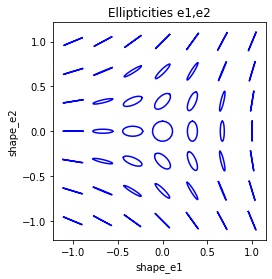

In [7]:
# We plot a grid of galaxies with different ellipticity components e1,e2.
n1, n2 = 7, 7
E1, E2 = np.meshgrid(np.linspace(-1., 1., n1), np.linspace(-1., 1., n2))
angle = np.linspace(0., 2. * np.pi, 20)
xy = np.vstack((np.sin(angle), np.cos(angle)))
for e1, e2 in zip(E1.ravel(), E2.ravel()):
    e = EllipseE(np.exp(6), e1, e2)
    T = e.getRaDecBasis()
    txy = np.dot(T, xy)
    plt.plot(e1 + txy[0, :], e2 + txy[1, :], '-', color='b')
plt.xlabel('shape_e1')
plt.ylabel('shape_e2')
plt.axis('scaled')
plt.title('Ellipticities e1,e2');

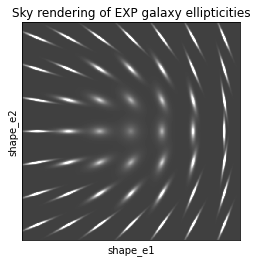

In [37]:
# Next, we'll render galaxy models with these ellipticities
from tractor.psf import NCircularGaussianPSF
from tractor import Image, NullWCS, ConstantFitsWcs, LinearPhotoCal, PixPos, RaDecPos, Flux, Tractor, EllipseESoft, ExpGalaxy
from astrometry.util.util import Tan
W, H = 500, 500
img = np.zeros((H, W), np.float32)
sig1 = 1.
pixscale = 0.262
# Create a typical north-up, east-left WCS
ps = pixscale/3600
wcs = Tan(0., 0., (W+1)/2., (H+1)/2., -ps, 0., 0., ps, float(W), float(H))
# PSF model: we'll assume 1" FWHM seeing with a Gaussian PSF shape.
# The PSF model class we're using takes Gaussian sigma in pixels rather than FWHM, so factor of 2.35
seeing = 1.
psf = NCircularGaussianPSF([seeing / pixscale / 2.35], [1.])
# Create a fake Tractor image object
tim = Image(data=img, inverr=np.zeros_like(img) + (1. / sig1),
            psf=psf, wcs=ConstantFitsWcs(wcs),
            photocal=LinearPhotoCal(1.))
# Could also work in pixel space:
# wcs=NullWCS(pixscale=pixscale)
# Create a catalog of galaxies with different ellipticities
cat = []
x = np.linspace(0, W, n1, endpoint=False)
x += (x[1] - x[0]) / 2.
y = np.linspace(0, H, n2, endpoint=False)
y += (y[1] - y[0]) / 2.
xx, yy = np.meshgrid(x, y)
rr, dd = wcs.pixelxy2radec(xx, yy)
for e1, e2, x, y, r, d in zip(E1.ravel(), E2.ravel(), xx.ravel(), yy.ravel(), rr.ravel(), dd.ravel()):
    e = EllipseE(5., e1, e2)
    #pos = PixPos(x, y)
    pos = RaDecPos(r, d)
    gal = ExpGalaxy(pos, Flux(1000. * sig1), e)
    cat.append(gal)
ima = dict(interpolation='nearest', origin='lower', cmap='gray',
           vmin=-1 * sig1, vmax=3 * sig1)
tractor = Tractor([tim], cat)
mod = tractor.getModelImage(0)
plt.imshow(mod, **ima);
plt.xticks([]); plt.yticks([])
plt.xlabel('shape_e1')
plt.ylabel('shape_e2')
plt.title('Sky rendering of EXP galaxy ellipticities');

Next, we'll examine a couple of real galaxies to show their radii.

In [39]:
# The LegacySurveyData object handles finding files on disk, among other things
survey = LegacySurveyData('/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/south')

In [40]:
# This is a specific galaxy I selected to examine.
brick, objid = '1764p197', 2721
# Find the tractor file and read it
filename = survey.find_file('tractor', brick=brick)
T = fits_table(filename)
# Select just the single galaxy we want.
t = (T[T.objid == objid])[0]
print(t.shape_r, t.shape_e1, t.shape_e2)

10.304247 -0.4207842 0.49765694


In [41]:
# Find the JPEG image of this brick
fn = survey.find_file('image-jpeg', brick=brick)
# The way JPEGs get read, they're vertically flipped wrt FITS coordinates.
img = np.flipud(plt.imread(fn))

In [42]:
# Create a FITS WCS header for this brick.
brickobj = survey.get_brick_by_name(brick)
wcs = wcs_for_brick(brickobj)

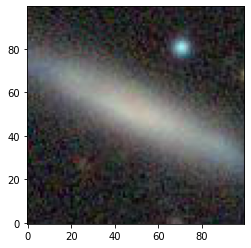

In [52]:
# Show the JPEG image cutout of this galaxy.
x,y = int(t.bx), int(t.by)
S=100
x0 = x-S//2
y0 = y-S//2
# Pull out the subimage of the JPEG
subimg = img[y0:y0+S, x0:x0+S]
sh,sw,x = subimg.shape
# Here we create a WCS object for the subimage.
subwcs = wcs.get_subimage(x0, y0, sw, sh)
plt.imshow(subimg, origin='lower');

In [47]:
# Create a tractor ellipse object for this galaxy, and compute where 1 r_e is.
ell = EllipseE(t.shape_r, t.shape_e1, t.shape_e2)
# the getRaDecBasis() function returns a matrix that converts r_e to delta_RA, delta_Dec
R = ell.getRaDecBasis()
angle = np.linspace(0., 2. * np.pi, 30)
xx, yy = np.sin(angle), np.cos(angle)
xy = np.vstack((xx,yy))
dra,ddec = np.dot(R, xy)

In [48]:
# Also compute locations of major and minor axes
vxy = np.array([[0, 1], [0,0], [1,0]]).T
vdra,vddec = np.dot(R, vxy)

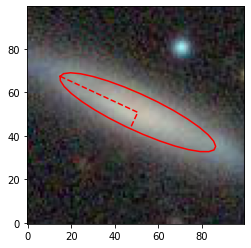

In [53]:
# Plot 1 r_e contour, converting to RA,Dec then to pixels.
cosdec = np.cos(np.deg2rad(t.dec))
ra  = t.ra  + dra / cosdec
dec = t.dec + ddec
ok,xx,yy = subwcs.radec2pixelxy(ra, dec)
ok,vx,vy = subwcs.radec2pixelxy(t.ra + vdra/cosdec, t.dec + vddec)
plt.imshow(subimg, origin='lower');
ax = plt.axis()
# The -1s here are to convert FITS 1-indexed pixels to numpy 0-indexed arrays
plt.plot(xx-1, yy-1, 'r-')
plt.plot(vx-1, vy-1, 'r--')
plt.axis(ax);

In [56]:
# Repeat for a second example galaxy that is more round.
brick, objid = '1745p200', 3017

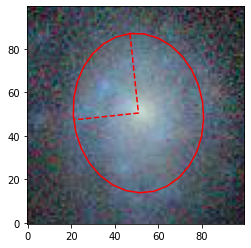

In [57]:
fn = survey.find_file('tractor', brick=brick)
T = fits_table(fn)
t = (T[T.objid == objid])[0]
fn = survey.find_file('image-jpeg', brick=brick)
img = np.flipud(plt.imread(fn))
brickobj = survey.get_brick_by_name(brick)
wcs = wcs_for_brick(brickobj)
x,y = int(t.bx), int(t.by)
S=100
x0 = x-S//2
y0 = y-S//2
subimg = img[y0:y0+S, x0:x0+S]
sh,sw,x = subimg.shape
subwcs = wcs.get_subimage(x0, y0, sw, sh)
ell = EllipseE(t.shape_r, t.shape_e1, t.shape_e2)
R = ell.getRaDecBasis()
angle = np.linspace(0., 2. * np.pi, 30)
xx, yy = np.sin(angle), np.cos(angle)
xy = np.vstack((xx,yy))
dra,ddec = np.dot(R, xy)
vxy = np.array([[0, 1], [0,0], [1,0]]).T
vdra,vddec = np.dot(R, vxy)
cosdec = np.cos(np.deg2rad(t.dec))
ra = t.ra + dra / cosdec
dec = t.dec + ddec
ok,xx,yy = subwcs.radec2pixelxy(ra, dec)
ok,vx,vy = subwcs.radec2pixelxy(t.ra + vdra/cosdec, t.dec + vddec)
plt.imshow(subimg, origin='lower');
ax = plt.axis()
plt.plot(xx-1, yy-1, 'r-')
plt.plot(vx-1, vy-1, 'r--')
plt.axis(ax);

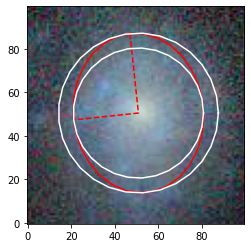

In [59]:
# Plot the minor and major axis radii as well.
e = ell.e
ab = (1 - e) / (1 + e)
rx,ry = np.cos(angle), np.sin(angle)
pix_r = t.shape_r / subwcs.pixel_scale()
ok,cx,cy = subwcs.radec2pixelxy(t.ra, t.dec)
plt.imshow(subimg, origin='lower');
ax = plt.axis()
plt.plot(xx-1, yy-1, 'r-')
plt.plot(vx-1, vy-1, 'r--')
plt.plot(cx-1+pix_r*rx, cy-1+pix_r*ry, 'w-')
plt.plot(cx-1+pix_r*rx*ab, cy-1+pix_r*ry*ab, 'w-')
plt.axis(ax);